In [1]:
!pip install torch transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!git config --global credential.helper store

In [3]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, OPTForSequenceClassification
from transformers import AutoTokenizer, AlbertForSequenceClassification
from transformers import AutoTokenizer, GPT2ForSequenceClassification
import time
from sklearn.metrics import classification_report

In [4]:
dataset = load_dataset("./sentiment140.py", name="sentiment140")

The repository for sentiment140 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sentiment140.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
from huggingface_hub import login
token = ""

num_labels = 2

model_name = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, token=token)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def map_labels(example):
    example["sentiment"] = 0 if example["sentiment"] == 0 else 1
    return example

dataset = dataset.map(map_labels)

Map:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

In [7]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Convert to pandas
df = dataset['train'].to_pandas()

_, df_balanced = train_test_split(
    df,
    stratify=df["sentiment"],
    test_size=0.1,
    random_state=42
)

# train_dataset_small = Dataset.from_pandas(df_balanced)
# train_dataset_small = train_dataset_small.remove_columns(["__index_level_0__"])
print(len(df_balanced))

# Step 2: Stratified split (70/30)
df_train, df_temp = train_test_split(
    df_balanced,
    stratify=df_balanced["sentiment"],
    test_size=0.3,
    random_state=42
)

# Step 3: Split remaining 30% into val/test (50/50)
df_val, df_test = train_test_split(
    df_temp,
    stratify=df_temp["sentiment"],
    test_size=0.5,
    random_state=42
)

print(len(df_train))
print(len(df_val))
print(len(df_test))

# Step 4: Convert back to Hugging Face Datasets
train_dataset = Dataset.from_pandas(df_train).remove_columns(["__index_level_0__"])
val_dataset = Dataset.from_pandas(df_val).remove_columns(["__index_level_0__"])
test_dataset = Dataset.from_pandas(df_test).remove_columns(["__index_level_0__"])

# Step 5: Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

# Step 6: Tokenize each split
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset   = val_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

# Step 7: Set PyTorch format
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "sentiment"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "sentiment"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "sentiment"])

# (Optional) Wrap in a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Print sizes to confirm
print(f"Train:     {len(dataset['train'])}")
print(f"Validation:{len(dataset['validation'])}")
print(f"Test:      {len(dataset['test'])}")

160000
112000
24000
24000


Map:   0%|          | 0/112000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Train:     112000
Validation:24000
Test:      24000


In [8]:
train_loader = DataLoader(dataset['train'], batch_size=32, shuffle=True)
val_loader = DataLoader(dataset['validation'], batch_size=32, shuffle=True)
test_loader = DataLoader(dataset['test'], batch_size=32)

In [9]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-5,                 # Learning rate - adjust as needed
    eps=1e-8,                # Epsilon - for numerical stability
    weight_decay=0.01,       # Weight decay - regularization
    betas=(0.9, 0.999)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=


Test Accuracy   : 0.5002
F1 Score (macro): 0.3361
F1 Score (weighted): 0.3361
Inference Time  : 190.45s

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67     12000
    Positive       0.53      0.00      0.01     12000

    accuracy                           0.50     24000
   macro avg       0.51      0.50      0.34     24000
weighted avg       0.51      0.50      0.34     24000



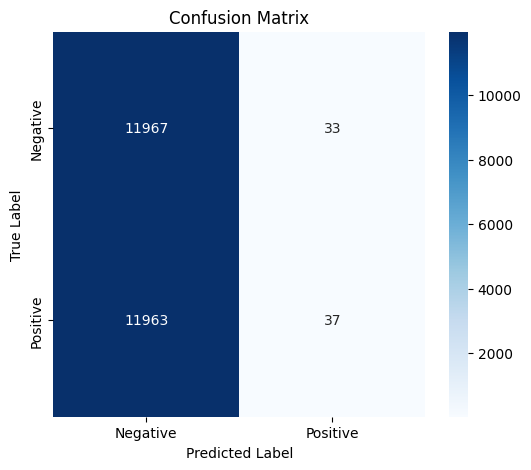

In [ ]:
import time
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

inference_start = time.time()

model.eval()
total_correct = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
f1_macro = f1_score(all_labels, all_preds, average="macro")
f1_weighted = f1_score(all_labels, all_preds, average="weighted")
inference_time = time.time() - inference_start

print(f"\nTest Accuracy   : {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Inference Time  : {inference_time:.2f}s")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# LORA

In [ ]:
!pip install peft

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

lora_config = LoraConfig(
    r=8,                               # LoRA rank
    lora_alpha=32,                     # Scaling factor
    lora_dropout=0.1,                  # Dropout for LoRA layers
    bias="none",                       # Don't train bias terms
    task_type=TaskType.SEQ_CLS,       # Task type: Sequence Classification
    target_modules=["query", "key", "value"]  # ALBERT attention projection layers
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 38,402 || all params: 11,723,524 || trainable%: 0.3276


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from transformers import get_scheduler

num_epochs = 3
best_val_f1 = 0.0
best_model_state = None

total_train_start = time.time()

num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{num_epochs} - Training Loss: {avg_loss:.4f}")

    # 🔍 Validation evaluation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["sentiment"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Validation Accuracy: {val_accuracy:.4f} - F1 (macro): {val_f1:.4f}")

    # 💾 Save best model (optional)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()  # or `copy.deepcopy(model.state_dict())`

total_train_time = time.time() - total_train_start
print(f"\nTotal Training Time: {total_train_time:.2f}s")

# (Optional) Load best model
# model.load_state_dict(best_model_state)


Epoch 1/3 - Training Loss: 0.5322
Validation Accuracy: 0.7998 - F1 (macro): 0.7996

Epoch 2/3 - Training Loss: 0.4242
Validation Accuracy: 0.8172 - F1 (macro): 0.8172

Epoch 3/3 - Training Loss: 0.4116
Validation Accuracy: 0.8176 - F1 (macro): 0.8176

Total Training Time: 6309.48s



Test Accuracy   : 0.8209
F1 Score (macro): 0.8209
F1 Score (weighted): 0.8209
Inference Time  : 195.92s

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82     12000
    Positive       0.83      0.81      0.82     12000

    accuracy                           0.82     24000
   macro avg       0.82      0.82      0.82     24000
weighted avg       0.82      0.82      0.82     24000



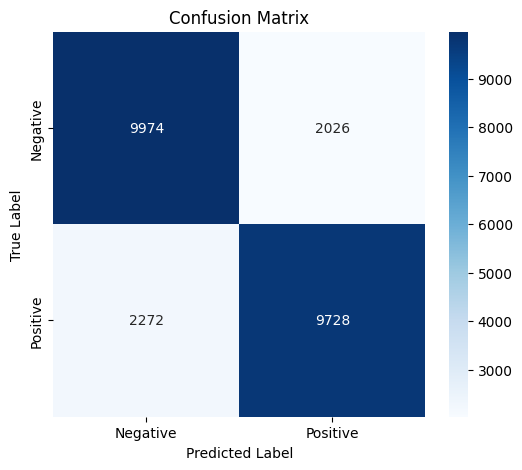

In [ ]:
import time
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

inference_start = time.time()

model.eval()
total_correct = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
f1_macro = f1_score(all_labels, all_preds, average="macro")
f1_weighted = f1_score(all_labels, all_preds, average="weighted")
inference_time = time.time() - inference_start

print(f"\nTest Accuracy   : {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Inference Time  : {inference_time:.2f}s")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
if torch.cuda.is_available():
    max_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
    print(f"Max GPU memory used: {max_memory:.2f} MB")

Max GPU memory used: 3914.88 MB


# BITFIT

In [10]:
from huggingface_hub import login
token = ""

num_labels = 2

model_name = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, token=token)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
for name, param in model.named_parameters():
    if "bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [12]:
trainable = [name for name, param in model.named_parameters() if param.requires_grad]
print(f"Trainable parameters: {trainable}")

Trainable parameters: ['albert.embeddings.LayerNorm.bias', 'albert.encoder.embedding_hidden_mapping_in.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.dense.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.LayerNorm.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.ffn.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.ffn_output.bias', 'albert.pooler.bias', 'classifier.bias']


In [13]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=2e-5
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

num_epochs = 3
best_val_f1 = 0.0
best_model_state = None

total_train_start = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{num_epochs} - Training Loss: {avg_loss:.4f}")

    # 🔍 Validation evaluation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["sentiment"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Validation Accuracy: {val_accuracy:.4f} - F1 (macro): {val_f1:.4f}")

    # 💾 Save best model (optional)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()  # or `copy.deepcopy(model.state_dict())`

total_train_time = time.time() - total_train_start
print(f"\nTotal Training Time: {total_train_time:.2f}s")

# (Optional) Load best model
# model.load_state_dict(best_model_state)


Epoch 1/3 - Training Loss: 0.6248
Validation Accuracy: 0.7495 - F1 (macro): 0.7491

Epoch 2/3 - Training Loss: 0.5288
Validation Accuracy: 0.7684 - F1 (macro): 0.7683


In [ ]:
import time
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

inference_start = time.time()

model.eval()
total_correct = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
f1_macro = f1_score(all_labels, all_preds, average="macro")
f1_weighted = f1_score(all_labels, all_preds, average="weighted")
inference_time = time.time() - inference_start

print(f"\nTest Accuracy   : {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Inference Time  : {inference_time:.2f}s")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
if torch.cuda.is_available():
    max_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
    print(f"Max GPU memory used: {max_memory:.2f} MB")